In [2]:
# idea:
# use 5 years data: 2016.1.1 - 2021.1.1 to train the model
# use 1 years data: 2020.1.1 - 2021.1.1 to find a good policy. 
# policy 1: choose the stock with maximum value, sell it when a) a stop loss/gain threshold is met.
# test it use 2021.1.1 to now.
import os
import pandas as pd
import json
from sklearn import linear_model
import numpy as np

import matplotlib.pyplot as plt
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [3]:
def stack_table(df):
    df = df.drop(index=df.index[-1], axis=0)
    df_stack = df[['timestamp', 'open', 'close']].set_index('timestamp').stack()
    time_list = pd.Series([time + pd.Timedelta(hours=6.5) if time_type == 'close' else time for time, time_type in df_stack.index])
    df_stack = df_stack.reset_index().rename(columns={0: "price"}).drop(['timestamp', 'level_1'], axis=1)
    df_stack['timestamp'] = time_list
    df_stack['price_log'] = np.log(df_stack['price'])
    df_stack['price_log_diff'] = df_stack['price_log'].diff()
    df_stack.sort_values(by='timestamp', inplace=True)
    return df_stack

In [4]:
def add_value(df):
  df['value']=0
  for i in range(20):
    df['value']=df['price_log_diff'].shift(-1).fillna(0)+0.9*df['value'].shift(-1).fillna(0)
  return df

In [5]:
stock_name = 'MSFT'
path = os.path.join('../data/stocks', stock_name)

In [6]:
df = pd.read_json(os.path.join(path, 'daily/data'))

In [7]:
df.head()

,timestamp,open,high,low,close,volumn,date
0,2002-07-09 13:30:00,26.655001,27.365,26.485001,26.605000,85277200,20020709
1,2002-07-10 13:30:00,26.844999,27.100,26.065001,26.120001,90673400,20020710
2,2002-07-11 13:30:00,26.020000,26.535,25.625000,26.455000,129550600,20020711
3,2002-07-12 13:30:00,26.684999,26.865,25.740000,25.930000,95733800,20020712
4,2002-07-15 13:30:00,25.695000,25.930,24.000000,25.900000,136965600,20020715


In [16]:
df_stack = stack_table(df)

In [17]:
df = add_value(df_stack)

In [18]:
df

,price,timestamp,price_log,price_log_diff,value
0,26.655001,2002-07-09 13:30:00,3.282977,NaN,-0.037795
1,26.605000,2002-07-09 20:00:00,3.281099,-0.001878,-0.050419
2,26.844999,2002-07-10 13:30:00,3.290080,0.008980,-0.070015
3,26.120001,2002-07-10 20:00:00,3.262701,-0.027378,-0.033606
4,26.020000,2002-07-11 13:30:00,3.258865,-0.003836,-0.035376
...,...,...,...,...,...
10065,262.850006,2022-07-05 20:00:00,5.571584,0.025781,0.017414
10066,263.750000,2022-07-06 13:30:00,5.575002,0.003418,0.015551
10067,266.209991,2022-07-06 20:00:00,5.584285,0.009284,0.006963
10068,265.119995,2022-07-07 13:30:00,5.580183,-0.004103,0.012296


In [19]:
import math

def linear_regression(df_input, period):
  print('starting linear regression:' + str(period))
  PERIOD=period
  df = df_input.copy()
  df.dropna(inplace=True)
  df.reset_index(inplace=True)
  df.drop('index',axis=1, inplace=True)
  df['price_log_error_' + str(period)] = 0
  # we start from the 10th row.
  for i in range(10, len(df)):
    start = max(i - period, 0)
    end = i
    x=df['timestamp'][start:end].astype(np.int64).values.reshape(-1, 1)
    y=df['price_log'][start:end].astype(np.int64).values.reshape(-1, 1)
    model = linear_model.LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    df['price_log_error_' + str(period)][i] = y_pred[-1] - df['price_log'][i]    
    
  df['price_log_error_' + str(period)][0:10] = math.nan
  df.reset_index(inplace=True)
  df.drop('index',axis=1, inplace=True)
  df.dropna(inplace=True)
  return df

In [20]:

df = linear_regression(df, 126)
# df = linear_regression(df, 253)
# df = linear_regression(df, 253 * 2)
# df = linear_regression(df, 253 * 4)
# df = linear_regression(df, 253 * 8)

starting linear regression:126


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10059 entries, 10 to 10068
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   price                10059 non-null  float64       
 1   timestamp            10059 non-null  datetime64[ns]
 2   price_log            10059 non-null  float64       
 3   price_log_diff       10059 non-null  float64       
 4   value                10059 non-null  float64       
 5   price_log_error_126  10059 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 550.1 KB


In [22]:
df.corr()['value']

price                  0.018548
price_log              0.033058
price_log_diff        -0.062430
value                  1.000000
price_log_error_126    0.020116
Name: value, dtype: float64

In [23]:
rootdir = '../data/indicators'
indicators_list = []
for subdir, dirs, files in os.walk(rootdir):
  for dir in dirs:
    name = dir
    if '=' in name:
      indicators_list.append(name)

In [24]:
indicators_list
 

['GC=F',
 'HG=F',
 'ZS=F',
 'ZB=F',
 'EURSEK=X',
 'SB=F',
 'EUR=X',
 'LE=F',
 'CL=F',
 'SI=F',
 'SEK=X']

In [25]:
import functools

def rename_dataframe(df, name):
  map = {'price': 'price_' + name,
                            'price_log': 'price_log_' + name,
                            'price_log_diff': 'price_log_diff_' + name,
                            'price_log_error': 'price_log_error_' + name
                            }
  price_log_error_list = [name for name in df.columns if name.startswith('price_log_error')]

  map = functools.reduce(lambda a, b: {b: b + '_' + name, **a}, price_log_error_list, map)
  return df.rename(columns=map)

In [26]:
df_test = pd.DataFrame(data={'price_log_error_253': [1,2], 'price_log_error_259': [3,4]})
rename_dataframe(df_test, 'test')

,price_log_error_253_test,price_log_error_259_test
0,1,3
1,2,4


In [27]:
for indicator in indicators_list:
    print('merging indicator: ' + indicator)
    path = os.path.join('../data/indicators', indicator)
    df_ind = pd.read_json(os.path.join(path, 'daily', 'data')).dropna()
    df_stack_ind = stack_table(df_ind)
    df_stack_ind_err = linear_regression(df_stack_ind, 126)
    # df_stack_ind_err = linear_regression(df_stack_ind_err, 253)
    # df_stack_ind_err = linear_regression(df_stack_ind_err, 253 * 2)
    # df_stack_ind_err = linear_regression(df_stack_ind_err, 253 * 4)
    # df_stack_ind_err = linear_regression(df_stack_ind_err, 253 * 8)
    # df_stack_ind
    err_column_list = [name for name in df_stack_ind_err.columns if name.startswith('price_log_error')]
    print(err_column_list)
    df_stack_ind_err = rename_dataframe(df_stack_ind_err[['timestamp','price_log'] + err_column_list], indicator)
    print(df_stack_ind_err.head())
    df = pd.merge_asof(df, df_stack_ind_err, on='timestamp')


merging indicator: GC=F
starting linear regression:126
['price_log_error_126']
             timestamp  price_log_GC=F  price_log_error_126_GC=F
10 2002-07-17 10:30:00        5.760163                 -0.760163
11 2002-07-18 04:00:00        5.758902                 -0.758902
12 2002-07-18 10:30:00        5.758902                 -0.758902
13 2002-07-19 04:00:00        5.780435                 -0.780435
14 2002-07-19 10:30:00        5.780435                 -0.780435
merging indicator: HG=F
starting linear regression:126
['price_log_error_126']
             timestamp  price_log_HG=F  price_log_error_126_HG=F
10 2002-07-17 10:30:00       -0.313342                  0.313342
11 2002-07-18 04:00:00       -0.314711                  0.314711
12 2002-07-18 10:30:00       -0.318141                  0.318141
13 2002-07-19 04:00:00       -0.328504                  0.328504
14 2002-07-19 10:30:00       -0.336172                  0.336172
merging indicator: ZS=F
starting linear regression:126
['price

/home/ken/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


['price_log_error_126']
             timestamp  price_log_CL=F  price_log_error_126_CL=F
10 2002-07-17 10:30:00        3.327910                 -0.327910
11 2002-07-18 04:00:00        3.322154                 -0.322154
12 2002-07-18 10:30:00        3.316728                 -0.316728
13 2002-07-19 04:00:00        3.305054                 -0.305054
14 2002-07-19 10:30:00        3.326115                 -0.326115
merging indicator: SI=F
starting linear regression:126
['price_log_error_126']
             timestamp  price_log_SI=F  price_log_error_126_SI=F
10 2002-07-17 10:30:00        1.607436                 -0.607436
11 2002-07-18 04:00:00        1.603420                 -0.603420
12 2002-07-18 10:30:00        1.607436                 -0.607436
13 2002-07-19 04:00:00        1.621959                 -0.621959
14 2002-07-19 10:30:00        1.621959                 -0.621959
merging indicator: SEK=X
starting linear regression:126
['price_log_error_126']
             timestamp  price_log_SEK

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10059 entries, 0 to 10058
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   price                         10059 non-null  float64       
 1   timestamp                     10059 non-null  datetime64[ns]
 2   price_log                     10059 non-null  float64       
 3   price_log_diff                10059 non-null  float64       
 4   value                         10059 non-null  float64       
 5   price_log_error_126           10059 non-null  float64       
 6   price_log_GC=F                10058 non-null  float64       
 7   price_log_error_126_GC=F      10058 non-null  float64       
 8   price_log_HG=F                10058 non-null  float64       
 9   price_log_error_126_HG=F      10058 non-null  float64       
 10  price_log_ZS=F                10058 non-null  float64       
 11  price_log_error_126_ZS=F    

In [29]:
def reorder(df):

  columns_non_value = [name for name in df.columns if name != 'value']
  df = df[columns_non_value + ['value']]
  return df

In [30]:
df = reorder(df)

In [33]:
df.corr()['value'].sort_values(ascending=False)[:10]

value                       1.000000
price_log_ZB=F              0.085727
price_log_EURSEK=X          0.056502
price_log_SEK=X             0.055224
price_log_EUR=X             0.048549
price_log_error_126_ZB=F    0.044513
price_log_GC=F              0.044183
price_log_error_126_SI=F    0.037939
price_log_error_126_CL=F    0.034441
price_log                   0.033058
Name: value, dtype: float64

In [34]:
df.corr()['value'].sort_values(ascending=False)[-10:]

price_log_HG=F                  0.009502
price_log_error_126_HG=F        0.006152
price_log_error_126_SB=F        0.000148
price_log_error_126_ZS=F       -0.003717
price_log_ZS=F                 -0.005657
price_log_error_126_LE=F       -0.029183
price_log_CL=F                 -0.037496
price_log_error_126_EUR=X      -0.048549
price_log_error_126_EURSEK=X   -0.055270
price_log_diff                 -0.062430
Name: value, dtype: float64

In [35]:
rootdir = '../data/fred'
fred_list = []
for subdir, dirs, files in os.walk(rootdir):
  for dir in files:
    name = dir
    fred_list.append(name)

In [36]:
fred_list

['M2', 'GDP', 'CPI', 'UNRATE', 'M1SL']

In [37]:
for fred in fred_list:
    print('merging fred data: ' + fred)
    path = os.path.join('../data/fred', fred)
    df_fred = pd.read_csv(path).dropna()
    df_fred['timestamp']=pd.to_datetime(df_fred['DATE'])
    df_fred['price_log']=np.log(df_fred.iloc[:,1])
    # df_stack_ind
    df_fred = rename_dataframe(df_fred[['timestamp', 'price_log']], fred)
    df = pd.merge_asof(df, df_fred, on='timestamp')

merging fred data: M2
merging fred data: GDP
merging fred data: CPI
merging fred data: UNRATE
merging fred data: M1SL


/home/ken/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ken/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
df.corr()['value'].abs().sort_values(ascending=False).head(10)

value                           1.000000
price_log_ZB=F                  0.085727
price_log_diff                  0.062430
price_log_EURSEK=X              0.056502
price_log_error_126_EURSEK=X    0.055270
price_log_SEK=X                 0.055224
price_log_EUR=X                 0.048549
price_log_error_126_EUR=X       0.048549
price_log_CPI                   0.045266
price_log_error_126_ZB=F        0.044513
Name: value, dtype: float64

In [39]:
import os

if not os.path.isdir('data'):
    os.mkdir('data')

df.to_csv(f'./data/data-{stock_name}.csv')

In [40]:
import pandas as pd
df = pd.read_csv(f'./data/data-{stock_name}.csv')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10059 entries, 0 to 10058
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    10059 non-null  int64  
 1   price                         10059 non-null  float64
 2   timestamp                     10059 non-null  object 
 3   price_log                     10059 non-null  float64
 4   price_log_diff                10059 non-null  float64
 5   price_log_error_126           10059 non-null  float64
 6   price_log_GC=F                10058 non-null  float64
 7   price_log_error_126_GC=F      10058 non-null  float64
 8   price_log_HG=F                10058 non-null  float64
 9   price_log_error_126_HG=F      10058 non-null  float64
 10  price_log_ZS=F                10058 non-null  float64
 11  price_log_error_126_ZS=F      10058 non-null  float64
 12  price_log_ZB=F                10058 non-null  float64
 13  p

In [42]:
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.interpolate(method='bfill', limit_direction='backward')


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10059 entries, 0 to 10058
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    10059 non-null  int64  
 1   price                         10059 non-null  float64
 2   timestamp                     10059 non-null  object 
 3   price_log                     10059 non-null  float64
 4   price_log_diff                10059 non-null  float64
 5   price_log_error_126           10059 non-null  float64
 6   price_log_GC=F                10059 non-null  float64
 7   price_log_error_126_GC=F      10059 non-null  float64
 8   price_log_HG=F                10059 non-null  float64
 9   price_log_error_126_HG=F      10059 non-null  float64
 10  price_log_ZS=F                10059 non-null  float64
 11  price_log_error_126_ZS=F      10059 non-null  float64
 12  price_log_ZB=F                10059 non-null  float64
 13  p

<AxesSubplot:>

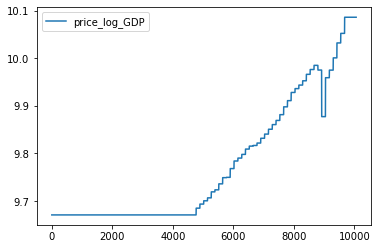

In [44]:
df[['price_log_GDP']].interpolate(method='index', limit_direction='backward').plot()

In [45]:
# # get-started/run-hello.py
# from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig

# ws = Workspace.get(name="stock",
#             subscription_id='fbc1bf20-ad59-475d-aa41-1dca1753160c',
#             resource_group='ken-ml')


In [46]:
# from sklearn.model_selection import train_test_split
# x_train, x_test = train_test_split(df, test_size=0.2, random_state=223)

In [47]:
# import logging

# automl_settings = {
#     "iteration_timeout_minutes": 20,
#     "experiment_timeout_hours": 10,
#     "enable_early_stopping": True,
#     "primary_metric": 'normalized_root_mean_squared_error',
#     "featurization": 'auto',
#     "verbosity": logging.INFO,
#     "n_cross_validations": 5
# }

In [48]:
# from azureml.train.automl import AutoMLConfig

# automl_config = AutoMLConfig(task='regression',
#                              debug_log='automated_ml_errors.log',
#                              training_data=x_train,
#                              label_column_name="value",
#                              **automl_settings)

In [49]:
# from azureml.core.experiment import Experiment
# experiment = Experiment(ws, "Stock")
# local_run = experiment.submit(automl_config, show_output=True)

In [50]:
column_list = [name for name in df.columns if name != 'value' and name != 'timestamp' and name != 'index']



In [51]:
column_list

['Unnamed: 0',
 'price',
 'price_log',
 'price_log_diff',
 'price_log_error_126',
 'price_log_GC=F',
 'price_log_error_126_GC=F',
 'price_log_HG=F',
 'price_log_error_126_HG=F',
 'price_log_ZS=F',
 'price_log_error_126_ZS=F',
 'price_log_ZB=F',
 'price_log_error_126_ZB=F',
 'price_log_EURSEK=X',
 'price_log_error_126_EURSEK=X',
 'price_log_SB=F',
 'price_log_error_126_SB=F',
 'price_log_EUR=X',
 'price_log_error_126_EUR=X',
 'price_log_LE=F',
 'price_log_error_126_LE=F',
 'price_log_CL=F',
 'price_log_error_126_CL=F',
 'price_log_SI=F',
 'price_log_error_126_SI=F',
 'price_log_SEK=X',
 'price_log_error_126_SEK=X',
 'price_log_M2',
 'price_log_GDP',
 'price_log_CPI',
 'price_log_UNRATE',
 'price_log_M1SL']

In [52]:
df.columns

Index(['Unnamed: 0', 'price', 'timestamp', 'price_log', 'price_log_diff',
       'price_log_error_126', 'price_log_GC=F', 'price_log_error_126_GC=F',
       'price_log_HG=F', 'price_log_error_126_HG=F', 'price_log_ZS=F',
       'price_log_error_126_ZS=F', 'price_log_ZB=F',
       'price_log_error_126_ZB=F', 'price_log_EURSEK=X',
       'price_log_error_126_EURSEK=X', 'price_log_SB=F',
       'price_log_error_126_SB=F', 'price_log_EUR=X',
       'price_log_error_126_EUR=X', 'price_log_LE=F',
       'price_log_error_126_LE=F', 'price_log_CL=F',
       'price_log_error_126_CL=F', 'price_log_SI=F',
       'price_log_error_126_SI=F', 'price_log_SEK=X',
       'price_log_error_126_SEK=X', 'value', 'price_log_M2', 'price_log_GDP',
       'price_log_CPI', 'price_log_UNRATE', 'price_log_M1SL'],
      dtype='object')

In [53]:
# Numerical pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

num_pipeline = Pipeline([ 
 ('imputer', SimpleImputer(strategy="mean")),
 ('std_scaler', StandardScaler() )])

num_pipeline_normalizer = Pipeline([ 
 ('imputer', SimpleImputer(strategy="mean")),
 ('normalizer', Normalizer() )])

# categorical pipeline
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([ 
 ('imputer', SimpleImputer(strategy="most_frequent")),
 ('OneHotEncoder', OneHotEncoder())
 ])


from sklearn.compose import ColumnTransformer

num_attribs = column_list
cat_attribs = []

# preprocess pipeline
from sklearn.compose import ColumnTransformer
column_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", cat_pipeline, cat_attribs)])
column_pipeline_normal = ColumnTransformer([("num", num_pipeline_normalizer, num_attribs),("cat", cat_pipeline, cat_attribs)])

In [54]:
#Train Data: From 2013-01-01 - 2021-01-01
df_train = df[df['timestamp']<'2018-01-01']
X, y = df_train[column_list], df_train['value']
df_test = df[df['timestamp']>='2018-01-01']
X_test, y_test = df_test[column_list], df_test['value']

In [55]:
X.min()

Unnamed: 0                       0.000000
price                           15.150000
price_log                        2.718001
price_log_diff                  -0.117462
price_log_error_126             -1.237513
price_log_GC=F                   5.712081
price_log_error_126_GC=F        -1.350750
price_log_HG=F                  -0.421594
price_log_error_126_HG=F        -1.280276
price_log_ZS=F                   6.213608
price_log_error_126_ZS=F        -1.269599
price_log_ZB=F                   4.640779
price_log_error_126_ZB=F        -1.314350
price_log_EURSEK=X               2.101729
price_log_error_126_EURSEK=X    -0.458015
price_log_SB=F                   1.678964
price_log_error_126_SB=F        -1.257716
price_log_EUR=X                 -0.469252
price_log_error_126_EUR=X        0.038304
price_log_LE=F                   4.161614
price_log_error_126_LE=F        -1.140849
price_log_CL=F                   3.226447
price_log_error_126_CL=F        -1.269815
price_log_SI=F                   1

In [56]:
column_pipeline.fit_transform(X)

array([[-1.73182839, -0.62867711, -0.68062906, ..., -0.78709971,
         0.63076222, -0.66899384],
       [-1.73138354, -0.58212868, -0.60711662, ..., -0.78709971,
         0.63076222, -0.66899384],
       [-1.73093868, -0.60118789, -0.63699899, ..., -0.78709971,
         0.63076222, -0.66899384],
       ...,
       [ 1.73093868,  3.77656247,  2.94572845, ...,  0.7867727 ,
        -2.5652333 ,  2.41129466],
       [ 1.73138354,  3.76996477,  2.94257356, ...,  0.7867727 ,
        -2.5652333 ,  2.41129466],
       [ 1.73182839,  3.76336762,  2.93941561, ...,  0.7867727 ,
        -2.5652333 ,  2.41129466]])

In [57]:
X

,Unnamed: 0,price,price_log,price_log_diff,price_log_error_126,price_log_GC=F,price_log_error_126_GC=F,price_log_HG=F,price_log_error_126_HG=F,price_log_ZS=F,...,price_log_error_126_CL=F,price_log_SI=F,price_log_error_126_SI=F,price_log_SEK=X,price_log_error_126_SEK=X,price_log_M2,price_log_GDP,price_log_CPI,price_log_UNRATE,price_log_M1SL
0,0,25.625000,3.243568,-0.001170,-0.243568,5.760163,-0.760163,-0.313342,0.313342,6.357409,...,-0.327910,1.607436,-0.607436,2.222036,-0.222036,9.192563,9.670437,-2.196669,2.140066,7.680499
1,1,26.260000,3.268047,0.024478,-0.268047,5.760163,-0.760163,-0.313342,0.313342,6.357409,...,-0.327910,1.607436,-0.607436,2.222936,-0.222936,9.192563,9.670437,-2.196669,2.140066,7.680499
2,2,26.000000,3.258097,-0.009950,-0.258097,5.760163,-0.760163,-0.313342,0.313342,6.357409,...,-0.327910,1.607436,-0.607436,2.222936,-0.222936,9.192563,9.670437,-2.196669,2.140066,7.680499
3,3,26.030001,3.259250,0.001153,-0.259250,5.758902,-0.758902,-0.318141,0.318141,6.358708,...,-0.316728,1.607436,-0.607436,2.221305,-0.221305,9.192563,9.670437,-2.196669,2.140066,7.680499
4,4,25.555000,3.240833,-0.018417,-0.240833,5.758902,-0.758902,-0.318141,0.318141,6.358708,...,-0.316728,1.607436,-0.607436,2.221305,-0.221305,9.192563,9.670437,-2.196669,2.140066,7.680499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,7782,85.709999,4.450969,0.000700,-0.450969,7.160069,-0.160069,1.180807,-0.180807,6.862235,...,0.239129,2.810547,-0.810547,2.122115,-0.122115,9.542116,9.897619,-0.607383,1.410987,8.191629
7783,7783,85.900002,4.453184,0.002214,-0.453184,7.165571,-0.165571,1.189671,-0.189671,6.851978,...,0.234004,2.823282,-0.823282,2.112062,-0.112062,9.542116,9.897619,-0.607383,1.410987,8.191629
7784,7784,85.720001,4.451086,-0.002098,-0.451086,7.165571,-0.165571,1.189671,-0.189671,6.851978,...,0.234004,2.823282,-0.823282,2.112062,-0.112062,9.542116,9.897619,-0.607383,1.410987,8.191629
7785,7785,85.629997,4.450036,-0.001051,-0.450036,7.174954,-0.174954,1.187691,-0.187691,6.858302,...,0.222180,2.836737,-0.836737,2.109694,-0.109694,9.542116,9.897619,-0.607383,1.410987,8.191629


In [59]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from tempfile import mkdtemp
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel


cachedir = mkdtemp()
full_pipeline = Pipeline([
    ('transform', column_pipeline),
    ('pca', PCA()),
    ('regress', 'passthrough')
], memory=cachedir)

N_COMPONENTS = (1, len(num_attribs))
N_FEATURES_OPTIONS = [2,4,8]
GAMMA_OPTIONS = [0.5, 1]
N_ITER=4
N_ITER_SMALL=1

param_grid = [({
    "pca__n_components": N_COMPONENTS,
    "regress": [RandomForestRegressor()],
    "regress__n_estimators":  (10, 100),
    "regress__criterion": ["squared_error"],
    "regress__max_depth": (10,20),
    "regress__min_samples_split": (2,16),
}, N_ITER),
({
    "pca__n_components": N_COMPONENTS,
    "regress": [XGBRegressor()],
    "regress__gamma": (0.5, 5),
    "regress__subsample": (0.6, 1.0),
    'regress__min_child_weight': (1, 10),
    "regress__colsample_bytree": (0.6, 1.0),
    "regress__max_depth": (3, 5)
}, N_ITER),
({
    "pca__n_components": N_COMPONENTS,
    "regress": [svm.SVR()],
    "regress__C": (1,10),
    "regress__gamma": ["scale", "auto"],
    "regress__kernel": ["linear", "poly", "rbf", "sigmoid"]
}, N_ITER),
({
    "pca__n_components": N_COMPONENTS,
    "regress": [lgb.LGBMRegressor()],
    "regress__num_leaves": (31, 127),
    "regress__reg_alpha": [0.1, 0.5],
    "regress__min_data_in_leaf": [30, 50, 100, 300, 400],
    "regress__lambda_l1": [0, 1, 1.5],
    "regress__lambda_l2": [0, 1]
}, N_ITER)]

In [63]:
from skopt import BayesSearchCV
import os
from skopt import dump, load
import ray
import tqdm

cb_times = 0
p_bar = tqdm(total=len(param_grid) * N_ITER)
def cb(v):
    p_bar.update(1)
    print('test')
    

# TODO : PROGRESS BAR
# TODO : customized scoring, use (y_hat - y) * y

PKL_FILENAME=f'./grid-{stock_name}.pkl'
#grid = GridSearchCV(full_pipeline, n_jobs=1, cv=3, scoring="accuracy", param_grid=param_grid)
if os.path.exists(PKL_FILENAME):
    grid = load(PKL_FILENAME)
else:
    # ray.init(address='auto')
    # register_ray()
    # with joblib.parallel_backend("ray"):
    grid =  BayesSearchCV(full_pipeline, n_jobs=-1, cv=5, scoring="neg_root_mean_squared_error", search_spaces=param_grid, verbose=3)
    grid.fit(X, y, callback = cb)
    #ray.shutdown()
    dump(grid, PKL_FILENAME)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END pca__n_components=19, regress=RandomForestRegressor(), regress__criterion=squared_error, regress__max_depth=19, regress__min_samples_split=12, regress__n_estimators=68;, score=-0.027 total time=  12.1s
[CV 3/5] END pca__n_components=19, regress=RandomForestRegressor(), regress__criterion=squared_error, regress__max_depth=19, regress__min_samples_split=12, regress__n_estimators=68;, score=-0.030 total time=  12.4s
[CV 2/5] END pca__n_components=19, regress=RandomForestRegressor(), regress__criterion=squared_error, regress__max_depth=19, regress__min_samples_split=12, regress__n_estimators=68;, score=-0.033 total time=  12.8s
[CV 4/5] END pca__n_components=19, regress=RandomForestRegressor(), regress__criterion=squared_error, regress__max_depth=19, regress__min_samples_split=12, regress__n_estimators=68;, score=-0.028 total time=  13.0s
[CV 5/5] END pca__n_components=19, regress=RandomForestRegressor(), regress__crit

In [90]:
ray.shutdown()

In [91]:
ray.nodes()

RaySystemError: System error: Ray has not been started yet. You can start Ray with 'ray.init()'.

In [94]:

# Only use price_log, price_log_diff, got -0.027 score.
# LGBMRegressor(lambda_l1=1.0, lambda_l2=1, min_data_in_leaf=100, num_leaves=65,
#              reg_alpha=0.19838982990813173)
# PCA(n_components=1)

#0.04 score:
#Index(['price_EURSEK=X', 'timestamp', 'price_log_EURSEK=X',

    #    'price_log_diff_EURSEK=X', 'price_CL=F', 'price_log_CL=F',
    #    'price_log_diff_CL=F', 'price_EUR=X', 'price_log_EUR=X',
    #    'price_log_diff_EUR=X', 'price_ZB=F', 'price_log_ZB=F',
    #    'price_log_diff_ZB=F', 'price_GC=F', 'price_log_GC=F',
    #    'price_log_diff_GC=F', 'price_HG=F', 'price_log_HG=F',
    #    'price_log_diff_HG=F', 'price_ZS=F', 'price_log_ZS=F',
    #    'price_log_diff_ZS=F', 'price_SEK=X', 'price_log_SEK=X',
    #    'price_log_diff_SEK=X', 'price_USDEUR=X', 'price_log_USDEUR=X',
    #    'price_log_diff_USDEUR=X', 'price_LE=F', 'price_log_LE=F',
    #    'price_log_diff_LE=F', 'price_SB=F', 'price_log_SB=F',
    #    'price_log_diff_SB=F', 'price_SI=F', 'price_log_SI=F',
    #    'price_log_diff_SI=F', 'price', 'price_log', 'price_log_diff'],
    #   dtype='object')
    # PCA(n_components=6)
    # XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #          colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
    #          gamma=4.868859599627096, gpu_id=-1, importance_type=None,
    #          interaction_constraints='', learning_rate=0.300000012,
    #          max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
    #          monotone_constraints='()', n_estimators=100, n_jobs=4,
    #          num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
    #          reg_lambda=1, scale_pos_weight=1, subsample=0.971239091414603,
    #          tree_method='exact', validate_parameters=1, verbosity=None)





pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_regress,param_regress__criterion,param_regress__max_depth,param_regress__min_samples_split,param_regress__n_estimators,...,param_regress__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
474,0.975887,0.056722,0.014359,0.001776,72,"LGBMRegressor(lambda_l1=1.0, lambda_l2=0, min_...",NaN,NaN,NaN,NaN,...,0.1,"{'pca__n_components': 72, 'regress': LGBMRegre...",-0.023967,-0.022967,-0.029592,-0.019793,-0.021286,-0.023521,0.003354,1
423,0.911423,0.112007,0.013728,0.001338,80,"LGBMRegressor(lambda_l1=1.0, lambda_l2=0, min_...",NaN,NaN,NaN,NaN,...,0.1,"{'pca__n_components': 80, 'regress': LGBMRegre...",-0.023800,-0.023027,-0.029736,-0.020149,-0.021169,-0.023576,0.003342,2
417,0.841467,0.062649,0.013278,0.001554,80,"LGBMRegressor(lambda_l1=1.0, lambda_l2=0, min_...",NaN,NaN,NaN,NaN,...,0.1,"{'pca__n_components': 80, 'regress': LGBMRegre...",-0.023800,-0.023027,-0.029736,-0.020149,-0.021169,-0.023576,0.003342,2
510,0.840830,0.059192,0.013760,0.001220,80,"LGBMRegressor(lambda_l1=1.0, lambda_l2=0, min_...",NaN,NaN,NaN,NaN,...,0.5,"{'pca__n_components': 80, 'regress': LGBMRegre...",-0.023862,-0.023278,-0.029687,-0.020066,-0.021135,-0.023606,0.003340,4
439,0.835651,0.052934,0.014176,0.001211,80,"LGBMRegressor(lambda_l1=1.0, lambda_l2=0, min_...",NaN,NaN,NaN,NaN,...,0.1,"{'pca__n_components': 80, 'regress': LGBMRegre...",-0.023862,-0.023278,-0.029687,-0.020066,-0.021135,-0.023606,0.003340,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.052810,0.009742,0.008337,0.002489,72,SVR(),NaN,NaN,NaN,NaN,...,NaN,"{'pca__n_components': 72, 'regress': SVR(), 'r...",-0.027320,-0.033349,-0.034195,-0.034386,-0.068072,-0.039465,0.014538,508
260,0.221985,0.055556,0.007393,0.001849,11,SVR(),NaN,NaN,NaN,NaN,...,NaN,"{'pca__n_components': 11, 'regress': SVR(), 'r...",-0.037770,-0.033673,-0.036882,-0.029511,-0.079486,-0.043465,0.018242,509
256,0.094654,0.030567,0.006644,0.000910,26,SVR(),NaN,NaN,NaN,NaN,...,NaN,"{'pca__n_components': 26, 'regress': SVR(), 'r...",-0.031793,-0.035441,-0.035730,-0.041758,-0.083398,-0.045624,0.019156,510
258,3.183070,0.174728,0.622225,0.027242,9,SVR(),NaN,NaN,NaN,NaN,...,NaN,"{'pca__n_components': 9, 'regress': SVR(), 're...",-207.129944,-102.597098,-335.252578,-410.537991,-2152.468904,-641.597303,762.791138,511


In [95]:
y.std()

0.023962260348407746

In [98]:
grid.best_estimator_.fit_predict()

Pipeline(memory='/tmp/tmp_7jfsend',
         steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'price',
                                                   'price_log',
                                                   'price_log_diff',
                                                   'price_log_error_126',
                                                   'price_log_error_253',
                                                   'price_log_error_506',
                                                   'price_log_error_1012',
                                         

In [99]:
grid.best_estimator_.fit(X,y)

Pipeline(memory='/tmp/tmp_7jfsend',
         steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'price',
                                                   'price_log',
                                                   'price_log_diff',
                                                   'price_log_error_126',
                                                   'price_log_error_253',
                                                   'price_log_error_506',
                                                   'price_log_error_1012',
                                         

In [103]:
y_pred = grid.best_estimator_.predict(X_test)

In [104]:
y_err = y_pred - y_test


In [112]:
y_err.min()

-0.11862238672277338

In [113]:
math.sqrt((y_err**2).sum()/len(y_err))

0.025349594773368685

In [114]:
y_test.std()

0.024585043132299936

In [126]:
y_test.mean() - y.mean()

0.0026624716098782196

In [134]:
y_test_err = y.mean() - y_test

math.sqrt((y_test_err**2).sum()/len(y_test))

0.024723329619131446

In [135]:
y_test_err

7779    -0.015265
7780    -0.021052
7781    -0.021629
7782    -0.020913
7783    -0.020381
           ...   
10012    0.055928
10013    0.051114
10014    0.044149
10015    0.031077
10016    0.001518
Name: value, Length: 2238, dtype: float64

In [136]:
y_err

7779    -0.013927
7780    -0.018443
7781    -0.019613
7782    -0.019345
7783    -0.017919
           ...   
10012    0.055303
10013    0.050489
10014    0.043524
10015    0.030452
10016    0.000892
Name: value, Length: 2238, dtype: float64

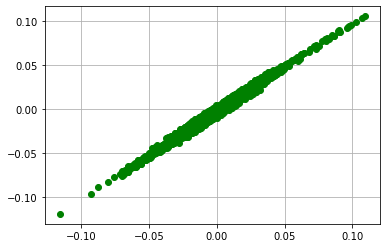

In [137]:
import matplotlib.pyplot as plt

plt.plot(y_test_err, y_err, 'go')
plt.grid()
plt.show()

In [125]:
y_test.mean()

0.004180000721577569

In [120]:
y_test.mean()

0.004180000721577569

In [149]:
guess_df = pd.DataFrame({'value': df['value'], 'guess': 0})

In [150]:
guess_df

,value,guess
0,-0.057961,0
1,-0.069508,0
2,-0.046247,0
3,-0.064049,0
4,-0.038463,0
...,...,...
10032,-0.063623,0
10033,-0.064064,0
10034,-0.037123,0
10035,-0.022711,0


In [151]:
guess_df['row_num'] = range(len(guess_df))

In [152]:
guess_df

,value,guess,row_num
0,-0.057961,0,0
1,-0.069508,0,1
2,-0.046247,0,2
3,-0.064049,0,3
4,-0.038463,0,4
...,...,...,...
10032,-0.063623,0,10032
10033,-0.064064,0,10033
10034,-0.037123,0,10034
10035,-0.022711,0,10035


In [153]:
for i in range(10000):
    guess_df['guess_shift'] = guess_df['guess'].shift(1, fill_value = 0)

    guess_df['guess'] = guess_df['guess_shift'] * (guess_df['row_num']-1)/guess_df['row_num'] + guess_df['value'].shift(1, fill_value=0) * 1/guess_df['row_num']
    guess_df.fillna(0, inplace=True)


In [168]:
guess_df[:-20]

,value,guess,row_num,guess_shift,error_square
0,-0.057961,0.000000,0,0.000000,0.003359
1,-0.069508,-0.057961,1,0.000000,0.000133
2,-0.046247,-0.063734,2,-0.057961,0.000306
3,-0.064049,-0.057905,3,-0.063734,0.000038
4,-0.038463,-0.059441,4,-0.057905,0.000440
...,...,...,...,...,...
10012,0.033583,0.005496,10012,0.005494,0.000789
10013,0.051893,0.005516,10013,0.005513,0.002151
10014,0.036868,0.005527,10014,0.005523,0.000982
10015,0.063740,0.005535,10015,0.005532,0.003388


In [157]:
guess_df[:29]['value'].mean()

-0.04761529688707347

In [158]:
guess_df['error_square'] = (guess_df['guess'] - guess_df['value'])**2

In [177]:
math.sqrt(guess_df.iloc[7000:8000]['error_square'].sum() / 1000)

0.021239852974002407

In [167]:
guess_df.iloc[40000:80000]

,value,guess,row_num,guess_shift,error_square


In [ ]:
grid.best_estimator_

In [ ]:
df.head()

In [ ]:
df = linear_regression(df)

In [ ]:
# calculate my own indicators
# current price - the averige price in n days.

df.head()

In [ ]:
df.Measurement.rolling